In [3]:
import numpy as np
from numpy import sqrt, exp
import math
from numpy import multiply, power, add, subtract
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import argrelextrema
from scipy import optimize

from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r args:[%r, %r] took: %2.4f sec' % \
          (f.__name__, args, kw, te-ts))
        return result
    return wrap

In [4]:
# Initialise parameters
S0 = 90      # initial stock price
K = 30       # strike price
T = 1         # time to maturity in years
H = 200      # up-and-out barrier price/value
r = 0.03      # annual risk-free rate
N = 3         # number of time steps
# u = 1.1       # up-factor in binomial models
# d = 1/u       # ensure recombining tree
deltaT = T/N
sigma = 0.3
# u = exp(sigma * sqrt(deltaT))
# d = 1.0 / u

In [5]:
def barrier_tree_slow(K,T,S0,H,r,N,u,d,opttype='C'):
    #precompute values
    dt = T/N
    q = (np.exp(r*dt) - d)/(u-d)
    disc = np.exp(-r*dt)
    
    # initialise asset prices at maturity
    S = np.zeros(N+1)
    for j in range(0,N+1):
        S[j] = S0 * u**j * d**(N-j)
        
    # option payoff
    C = np.zeros(N+1)
    for j in range(0,N+1):
        if opttype == 'C':
            C[j] = max(0, S[j] - K)
        else:
            C[j] = max(0, K - S[j])
            
    # check terminal condition payoff
    for j in range(0, N+1):
        S = S0 * u**j * d**(N-j)
        if S >= H:
            C[j] = 0
            
    # backward recursion through the tree
    for i in np.arange(N-1,-1,-1):
        for j in range(0,i+1):
            S = S0 * u**j * d**(i-j)
            if S >= H:
                C[j] = 0
            else:
                C[j] = disc * (q*C[j+1]+(1-q)*C[j])
    return C[0]

In [6]:
def barrier_tree_fast(K, T, S0, H, r, N, u, d, opttype='C'):
    #precompute values
    dt = T/N
    q = (np.exp(r*dt) - d)/(u-d)
    disc = np.exp(-r*dt)

    # initialise asset prices at maturity
    S = S0 * d**(np.arange(N, -1, -1)) * u**(np.arange(0, N+1, 1))
    print(S)
    # option payoff
    if opttype == 'C':
        C = np.maximum(S - K, 0)
    else:
        C = np.maximum(K - S, 0)

    # check terminal condition payoff
    C[S >= H] = 0

    # backward recursion through the tree
    for i in np.arange(N-1, -1, -1):
        S = S0 * d**(np.arange(i, -1, -1)) * u**(np.arange(0, i+1, 1))
        C[:i+1] = disc * (q * C[1:i+2] + (1-q) * C[0:i+1])
        C = C[:-1]
        C[S >= H] = 0
    
        # print(C)
    return C[0]


In [7]:
# for N in [3,50,100,1000]:
#     print(f"N:{N} , option price: {barrier_tree_slow(K,T,S0,H,r,N,u,d,opttype='C')}")
#     print(f"N:{N} , option price: {barrier_tree_fast(K,T,S0,H,r,N,u,d,opttype='C')}")

In [8]:
# print(barrier_tree_fast(K,T,S0,H,r,10,u,d,opttype='C'))

In [108]:

def barrier_tree_fast(K, T, S0, H, r, N, sigma,div, opttype='C', barriertype="uo"):


    #precompute values
    
    powerd = np.zeros(1+2*N)
    powerd[:N+1] = np.arange(N, -1, -1)

    poweru = np.zeros(1+2*N)
    poweru[N:] = np.arange(0, N+1, 1)

    
    powerm = np.arange(0, 1+2*N, 1., )
    powerm[N:] = np.arange(N, -1, -1)
 
    dt = T/N
    u = exp(sigma*sqrt(2*dt))
    d = 1/u
    m = u*d
    qu = ((math.exp((r-div) *
                    dt/2.) -
           math.exp(-sigma *
                    math.sqrt(dt/2.))) /
          (math.exp(sigma *
                    math.sqrt(dt/2.)) -
           math.exp(-sigma *
                    math.sqrt(dt/2.))))**2
    qd = ((math.exp(sigma *
                         math.sqrt(dt/2.)) -
                math.exp((r-div) *
                         dt/2.)) /
               (math.exp(sigma *
                         math.sqrt(dt/2.)) -
                math.exp(-sigma *
                         math.sqrt(dt/2.))))**2.
    qm = 1 - qu - qd
    disc = np.exp(-r*dt)

    
    # initialise asset prices at maturity
    S = S0*d**(powerd)*u**(poweru)*m**(powerm)
    # print(f"Stock array N={N}:{S}")
    # option payoff
    if opttype == 'C':
        C = np.maximum(S - K, 0)
    else:
        C = np.maximum(K - S, 0)
    
    # check terminal condition payoff
    if barriertype=="uo":
        C[S >= H] = 0
    elif barriertype =="do":
        C[S <= H] = 0

    # print(f"Option array N={N}:{C}")

    # backward recursion through the tree
    for i in np.arange(N-1, -1, -1):
       
        powerd = np.zeros(1+2*i)
        powerd[:i+1] = np.arange(i, -1, -1)
        poweru = np.zeros(1+2*i)
        poweru[i:] = np.arange(0, i+1, 1)
        powerm = np.arange(0, 1+2*i, 1., )
        powerm[i:] = np.arange(i, -1, -1)
        
        S = S0*d**(powerd)*u**(poweru)*m**(powerm)
        # print(f"Stock array N={i}:{S}")
        C[:1+2*i] = disc * (qd*C[:-2] + qm*C[1:-1]+ qu*C[2:])
        C = C[:1+2*i]
        
        if barriertype == "uo":
            C[S >= H] = 0
        elif barriertype == "do":
            C[S <= H] = 0
        # print(f"Option array N={i}:{C}")
        
        
    return C[0]


# Initialise parameters
S0 = 95      # initial stock price
K = 100      # strike price
T = 1         # time to maturity in years
H = 110   # up-and-out barrier price/value
r = 0.1      # annual risk-free rate
N = 4000         # number of time steps
sigma = 0.25  # standard deviation
div = 0        # dividend
barriertype = "uo"   # barrier type
optiontype = "P"     # option type

print(barrier_tree_fast(K, T, S0, H, r, N, sigma,div, opttype=optiontype, barriertype=barriertype))


5.777971058296163


In [157]:

min = 0 # local min time container
mincount=0 # local min count counter 
i = 1 # number of lattices
x = barrier_tree_fast(K, T, S0, H, r, i, sigma, div,opttype=optiontype, barriertype=barriertype) # barrier price at i-1
while i<=1000:
    i += 1 # count increase 
    y = barrier_tree_fast(K, T, S0, H, r, i, sigma, div,opttype=optiontype, barriertype=barriertype) # barrier price at i
    # print(f"{x-y} steps:{i} option price: {y}")
    
    if (x-y) < 0.0: # if difference between price at t-1 and t is negative => local min
        
        mincount+=1 # count increase
        # print(mincount)
        print(f"min: {x-y} steps:{i-1} option price: {x}")
        
        if mincount>=2: # making sure there are at least two min values so that I can add the difference 
            
            i = i+((i)-min) # changes time i to  local min at i plus difference between time i and previous local min time(i)
        min = i # changes time of last local min 
           
            
            
    # elif (x-y)>0.0:
    #     print(f"max: {x-y} steps:{i} option price: {y}")
    #     max = i
    x = y # changes x to i'th period option price



min: -1.2013567227115427 steps:5 option price: 5.943647290132938
min: -0.9680045884269664 steps:23 option price: 5.716959974519028
min: -0.7433771186437825 steps:52 option price: 5.692801635335866
min: -0.6066441098108228 steps:93 option price: 5.694071321754736
min: -0.5060190122694674 steps:145 option price: 5.695541782008736
min: -0.43428067350914556 steps:209 option price: 5.6921231669121175
min: -0.380543206585644 steps:284 option price: 5.696823209932804
min: -0.338450176962966 steps:372 option price: 5.691577039062489
min: -0.30464149455900813 steps:471 option price: 5.690677253003645
min: -0.27695161389516 steps:581 option price: 5.692694761277919
min: -0.25369618846092123 steps:703 option price: 5.692090957760199
min: -0.23420755693052087 steps:837 option price: 5.691529044835705
min: -0.21744245552347596 steps:982 option price: 5.692323186901098


In [ ]:


x = np.arange(1,1001,1)
y = np.array([])
for i in range(x[0], x[-1]+1):
    

    c = np.array(barrier_tree_fast(K, T, S0, H, r, i,sigma, div, opttype=optiontype, barriertype=barriertype))
    # print(c,i)
    
    y = np.append(y,c)
    

In [ ]:
y[argrelextrema(y,np.less)[:]][2:]
# argrelextrema(y,np.less)


array([5.69280164, 5.69407132, 5.69554178, 5.69212317, 5.69682321,
       5.69157704, 5.69067725, 5.69269476, 5.69209096, 5.69152904,
       5.69232319])

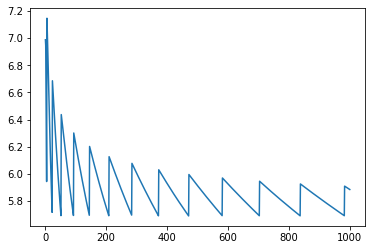

In [147]:
fig, ax = plt.subplots()
ax.plot(x,y)
